In [1]:
import cv2
import os
from PIL import Image
import numpy as np
#import Augmentor
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input  
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

2024-04-28 13:06:28.275229: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 13:06:28.275319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 13:06:28.410101: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_path = os.path.join('/kaggle/input/ultrasound/data')
dir_path = os.listdir(base_path)
dir_path.reverse()
print(dir_path)
files = []
labels = []

['malignant', 'normal', 'benign']


In [3]:
def img_preprocessing(img_path):
    img = load_img(img_path, target_size=(224, 224)) 
    img = img_to_array(img)  # Convert to NumPy array
    #img = np.expand_dims(img, axis=0)# Add a batch dimension (needed for the model)
    img = preprocess_input(img)  
    return img

In [4]:
for i, img_class in enumerate(dir_path):
    for image in os.listdir(os.path.join(base_path,img_class)):
        img_path = os.path.join(base_path,img_class,image)
        img_array = img_preprocessing(img_path)
        files.append(img_array)
        labels.append(i)

In [6]:
indices = np.arange(len(files))
np.random.shuffle(indices)
m_files = []
m_labels = []
for indice in indices:
    m_files.append(files[indice])
    m_labels.append(labels[indice])

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [8]:
x_train, x_test, y_train, y_test = train_test_split(m_files, m_labels, test_size = 0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=42)

In [9]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [10]:
count_0_val = np.sum(y_val == 0)
count_1_val = np.sum(y_val == 1)
count_2_val = np.sum(y_val == 2)

count_0_train = np.sum(y_train == 0)
count_1_train = np.sum(y_train == 1)
count_2_train = np.sum(y_train == 2)

count_0_test = np.sum(y_test == 0)
count_1_test = np.sum(y_test == 1)
count_2_test = np.sum(y_test == 2)

print(count_0_val, count_1_val, count_2_val)
print(count_0_train, count_1_train, count_2_train)
print(count_0_test, count_1_test, count_2_test)

81 59 70
271 303 264
85 75 103


In [11]:
y_train_encoded = to_categorical(y_train, num_classes=3)
#print(f'1: {y_train_encoded}')
y_train_encoded = y_train_encoded.reshape(-1, 3) 
#print(f'2: {y_train_encoded}')

y_val_encoded = to_categorical(y_val, num_classes=3)
y_val_encoded = y_val_encoded.reshape(-1, 3)


#x_test = to_categorical(y_train, num_classes=3)
#y_test = to_categorical(y_train, num_classes=3)

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization,Activation
from tensorflow.keras.initializers import GlorotUniform, HeNormal
import matplotlib.pyplot as plt
from keras import regularizers
from keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.regularizers import l2
from keras.models import load_model
from tensorflow.keras.models import save_model
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense, Concatenate
from tensorflow.keras.models import Model

In [56]:
base1 = DenseNet121(weights=None, include_top=False, input_shape=(224,224,3))
#base1.load_weights("/kaggle/input/chexnet-keras-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5", by_name=True, skip_mismatch=True)
base1.load_weights("/kaggle/input/radimagenet-densenet121/RadImageNet-DenseNet121_notop.h5")
#base1 = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))


In [57]:
base1.trainable = True

set_trainable = False

for layer in base1.layers:
    if layer.name in ['conv5_block15_2_conv','conv5_block15_1_conv','conv5_block16_2_conv','conv5_block16_1_conv']:
        layer.trainable = True
    else:
        layer.trainable = False          

In [42]:
inputs = base1.input

x = GlobalAveragePooling2D()(base1.output)
x = BatchNormalization()(x)
#x = Dropout(0.3)(x)

outputs = Dense(3, activation='softmax')(x)
model1 = Model(inputs, outputs)

model1.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
history1 = model1.fit(x_train, y_train_encoded ,validation_data=(x_val,y_val_encoded), epochs=30, batch_size=32) 

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 897ms/step - accuracy: 0.3982 - loss: 1.0906 - val_accuracy: 0.4476 - val_loss: 1.0691
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.5134 - loss: 0.9887 - val_accuracy: 0.4667 - val_loss: 1.0618
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5753 - loss: 0.9094 - val_accuracy: 0.4762 - val_loss: 1.0518
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.6186 - loss: 0.8823 - val_accuracy: 0.5190 - val_loss: 1.0494
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.5724 - loss: 0.8836 - val_accuracy: 0.4000 - val_loss: 1.0591
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.6200 - loss: 0.8553 - val_accuracy: 0.4381 - val_loss: 1.0492
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.6340 - loss: 0.8385 - val_accuracy: 0.3714 - val_loss: 1.0671
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.6380 - loss: 0.8094 - val_accuracy: 0.4762 -

In [43]:
model1.save('U_chex_121.h5')

In [50]:
inputs = base1.input

x = GlobalAveragePooling2D()(base1.output)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

outputs = Dense(3, activation='softmax')(x)

model2 = Model(inputs, outputs)

model2.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(x_train, y_train_encoded ,validation_data=(x_val,y_val_encoded), epochs=20, batch_size=32) 

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 887ms/step - accuracy: 0.5330 - loss: 1.0348 - val_accuracy: 0.5810 - val_loss: 0.9693
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8317 - loss: 0.4754 - val_accuracy: 0.6429 - val_loss: 0.9319
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9080 - loss: 0.3004 - val_accuracy: 0.7048 - val_loss: 0.8576
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9326 - loss: 0.2185 - val_accuracy: 0.7143 - val_loss: 0.8210
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9470 - loss: 0.1824 - val_accuracy: 0.7381 - val_loss: 0.7753
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9396 - loss: 0.1793 - val_accuracy: 0.7524 - val_loss: 0.7137
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9723 - loss: 0.1085 - val_accuracy: 0.7190 - val_loss: 0.6919
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9797 - loss: 0.0967 - val_accuracy: 0.7238 -

In [51]:
model2.save('U_Rad_121.h5')

In [58]:
inputs = base1.input

x = GlobalAveragePooling2D()(base1.output)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

outputs = Dense(3, activation='softmax')(x)

model3 = Model(inputs, outputs)

model3.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
history3 = model3.fit(x_train, y_train_encoded ,validation_data=(x_val,y_val_encoded), epochs=20, batch_size=32) 

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 884ms/step - accuracy: 0.5705 - loss: 1.0435 - val_accuracy: 0.6048 - val_loss: 1.3795
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.7666 - loss: 0.5621 - val_accuracy: 0.4143 - val_loss: 2.9373
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.8250 - loss: 0.4350 - val_accuracy: 0.6381 - val_loss: 1.0361
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.8570 - loss: 0.3427 - val_accuracy: 0.6286 - val_loss: 0.8497
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8980 - loss: 0.2704 - val_accuracy: 0.5857 - val_loss: 1.3566
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9074 - loss: 0.2496 - val_accuracy: 0.7905 - val_loss: 0.5083
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9423 - loss: 0.1736 - val_accuracy: 0.7714 - val_loss: 0.6174
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9314 - loss: 0.1845 - val_accuracy: 0.8190 -

In [60]:
model3.save('U_Img_121.h5')

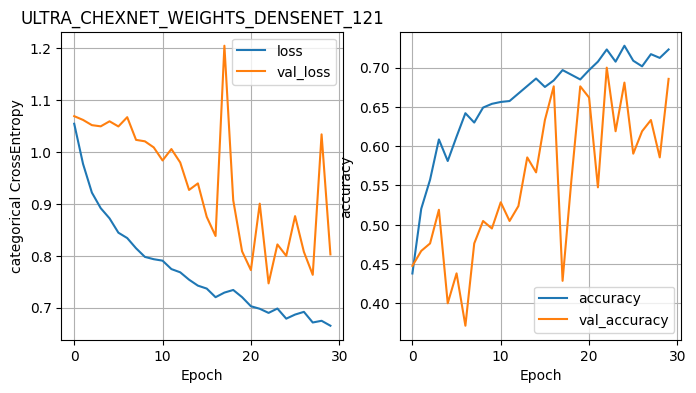

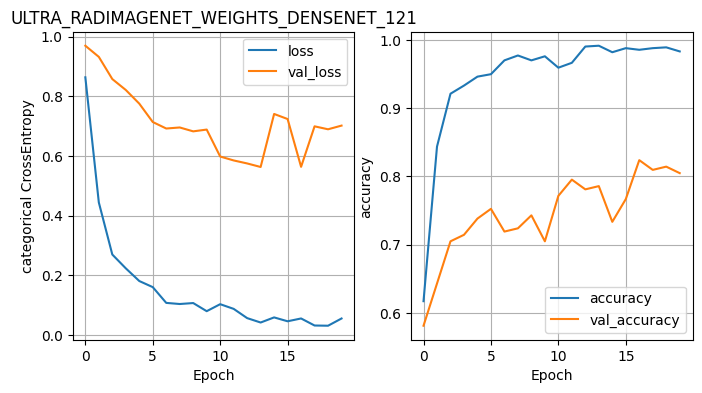

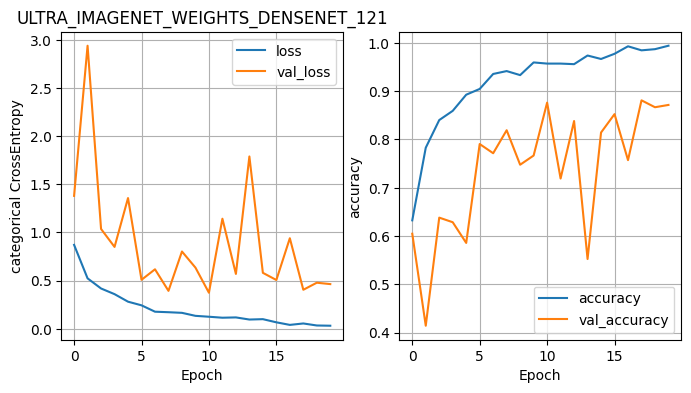

In [61]:
def plot_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('categorical CrossEntropy')
    ax1.legend() 
    ax1.grid(True)
    ax1.set_title(title)
    
    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()

plot_history(history1,'ULTRA_CHEXNET_WEIGHTS_DENSENET_121')
plot_history(history2,'ULTRA_RADIMAGENET_WEIGHTS_DENSENET_121')
plot_history(history3,'ULTRA_IMAGENET_WEIGHTS_DENSENET_121')

In [62]:
from sklearn.metrics import classification_report

# Assuming y_test is the true labels and x_test is the test data

models = [model1, model2, model3]  # Assuming model1, model2, and model3 are your three models
model_names = ['CHEXNET_WEIGHTS_DENSENET_121', 'RADIMAGENET_WEIGHTS_DENSENET_121', 'IMAGENET_WEIGHTS_DENSENET_121']

for model, name in zip(models, model_names):
    y_pred = model.predict(x_test)
    y_pred = (y_pred > 0.5).astype(int)
    y_pred = np.argmax(y_pred, axis=1)

    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))
    print()

9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step
Classification Report for CHEXNET_WEIGHTS_DENSENET_121:
              precision    recall  f1-score   support

           0       0.67      0.55      0.61        85
           1       0.66      0.72      0.69        75
           2       0.68      0.74      0.71       103

    accuracy                           0.67       263
   macro avg       0.67      0.67      0.67       263
weighted avg       0.67      0.67      0.67       263


9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step
Classification Report for RADIMAGENET_WEIGHTS_DENSENET_121:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83        85
           1       0.83      0.87      0.85        75
           2       0.87      0.83      0.85       103

    accuracy                           0.84       263
   macro avg       0.84      0.85      0.84       263
weighted avg       0.84      0.84      0.84       263


9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step
Classific